<a href="https://colab.research.google.com/github/lucasgneccoh/SGD_ICP_PY/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors implementation

In [ ]:
%%capture
%cd /content
!git clone https://bitbucket.org/fafz/sgd_icp.git
!sudo apt install libeigen3-dev
!sudo apt install libpcl-dev
%cd /content/sgd_icp
!mkdir build
%cd build
!cmake -DCMAKE_BUILD_TYPE=Release /content/sgd_icp
!make

In [ ]:
%%capture
%cd /content
!git clone https://github.com/lucasgneccoh/SGD_ICP_PY.git
!pip install lzf
'''
Setup pypcd
'''
%cd /content/SGD_ICP_PY/pypcd/
!python setup.py build
!python setup.py install

In [20]:
import os
import numpy as np
from pypcd import pypcd as pcd
from google.colab import files
import json
import matplotlib.pyplot as plt


def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

def roll_pitch_yaw(ax, ay, az):
  cx, sx = np.cos(ax), np.sin(ax)
  cy, sy = np.cos(ay), np.sin(ay)
  cz, sz = np.cos(az), np.sin(az)
  
  R = np.array([[cz*cy, cz*sx*sy-sz*cx, cz*sx*sy+sz*sy],
                [sz*cy, sz*sx*sy+cz*cx, sz*sx*sy-cz*sx],
                [-sy, cy*sx, cy*cx]])
  return R


def add_noise(pc, mean, std):
  return pc + np.random.normal(loc=mean, scale=std, size=pc.shape)

def apply_transform(pc, R, t):
  if isinstance(pc, pcd.PointCloud):
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    cloud = R.T @ cloud + t.reshape(-1,1)
    for a, i in zip(['x', 'y', 'z'], range(3)):
      pc.pc_data[a] = cloud[i,:]
  else:
    pc = R.T @ pc +  t.reshape(-1,1)    
  return pc


def read_pcd(path):
  pc = pcd.point_cloud_from_path(path)
  return np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])

def dropout(cloud, drop_prop):
  ind = (np.random.uniform(size=cloud.shape[1])>drop_prop)
  return cloud[:,ind]

def save_whole_cloud(paths_in, path_out):
  start = True
  whole = None
  for path_in in paths_in:
    pc = pcd.point_cloud_from_path(path_in)
    meta = pc.get_metadata()
    trans = np.array(meta['viewpoint'][:3])
    rot = quaternion_rotation_matrix(meta['viewpoint'][3:]).T
    
    cloud = np.vstack([pc.pc_data['x'], pc.pc_data['y'], pc.pc_data['z']])
    
    rotated = rot.T @ cloud + trans.reshape(-1,1)
    
    pc.pc_data['x'] = rotated[0,:]
    pc.pc_data['y'] = rotated[1,:]
    pc.pc_data['z'] = rotated[2,:]
    if start:
      start = False
      whole = pc
    else:
      whole = pcd.cat_point_clouds(whole, pc)
      
  whole.save_pcd(path_out)

In [6]:
'''
Build an unified cloud using different parts from the Bremen dataset
'''
%cd /content/SGD_ICP_PY
parts = [0, 1]
path_out = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen.pcd'

paths_in = ['/content/SGD_ICP_PY/data/pcd_bremen/pcd_bremen/scan_0{0:02d}.pcd'.format(i) for i in parts]
save_whole_cloud(paths_in, path_out)
# files.download(path_out) 

/content/SGD_ICP_PY


In [7]:
# Create a copy but rotated and translated to try to align them
x, y, z, roll, pitch, yaw = 1,3,0,0,0,np.pi/6
R, t = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
pc = pcd.point_cloud_from_path(path_out)
pc = apply_transform(pc, R, t)

path_out_mod = '/content/SGD_ICP_PY/data/pcd_bremen/my_bremen_mod.pcd'
pc.save_pcd(path_out_mod)
# files.download(path_out_mod)

In [ ]:
# Prepare config file
with open('/content/sgd_icp/config.json') as f:
  config_dict = json.load(f)
config_dict['normalize-cloud'] = True
initial_guess = {'x': -1.0, 'y': -3.0, 'z': 0.0, 'roll': 0.0, 'pitch': 0.0, 'yaw': round(np.pi/6,3)}
config_dict['initial-guess'] = initial_guess

config_path = '/content/sgd_icp/my_config.json'
with open(config_path, 'w') as f:
  json.dump(config_dict, f)

In [ ]:
# Test here. Uses PCD format for the clouds. Config file example is given in repository: JSON file with parameters
# align_pcd <source_cloud> <target_cloud> <cofig_file>
%cd /content/sgd_icp/bin
config_def = '/content/sgd_icp/config.json'
!./align_pcd $path_out $path_out_mod $config_def

/content/sgd_icp/bin
Iterations: 150 converged: 0
ICP Duration: 2375 ms
RMSE: 0.252047
Transformation_matrix:
  0.977377   0.207696 -0.0399691    2.07443
 -0.202106   0.972822    0.11301    2.04071
 0.0623544  -0.102375    0.99279   0.501015
         0          0          0          1
[x, y, z, roll, pitch, yaw] = [2.07443,2.04071,0.501015,-0.102755,-0.0623948,-0.20391]


In [ ]:
%cd /content/SGD_ICP_PY
# This values are the output of the sgd_icp method
x, y, z, roll, pitch, yaw = 0.859752,2.4057,-1.50104,0.298771,-0.998264,-0.386195
R, t = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
pc = pcd.point_cloud_from_path(path_out)
apply_transform(pc, R, t)
pc.save_pcd('./data/pcd_bremen/my_bremen_sgd_icp.pcd')
# files.download('./data/pcd_bremen/my_bremen_sgd_icp.pcd')

/content/SGD_ICP_PY
(2805929, 3)
(3, 3)
{'version': '.7', 'fields': ['x', 'y', 'z', 'intensity'], 'size': [4, 4, 4, 4], 'type': ['F', 'F', 'F', 'F'], 'count': [1, 1, 1, 1], 'width': 2805929, 'height': 1, 'viewpoint': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'points': 2805929, 'data': 'binary'}


# Python implementation using the code from class

In [8]:
%cd /content/SGD_ICP_PY/sgd_icp_python
import ICP
from ply_utils import read_ply
cloud = read_pcd('../data/pcd_bremen/my_bremen.pcd')

x, y, z, roll, pitch, yaw = 1,3,0,0,0,np.pi/6
R, t = roll_pitch_yaw(roll, pitch, yaw), np.array([x,y,z])
ref = apply_transform(cloud, R.T, t)

icp_cloud, R_list, T_list, _, RMS_list = ICP.icp_point_to_point(cloud, ref, 25, 1e-4, show_progress=True)

/content/SGD_ICP_PY/sgd_icp_python
15.028
13.596
11.809
10.571
9.722
9.098
8.513
7.857
7.184
6.578
6.105
5.737
5.378
4.962
4.532
4.064
3.509
2.969
2.539
2.172
1.864
1.580
1.312
1.070
0.862


In [22]:
icp_cloud, R_list, T_list, _, RMS_list = ICP.icp_point_to_point(icp_cloud, ref, 10, 1e-4, show_progress=True)

0.693
0.557
0.448
0.361
0.290
0.235
0.191
0.157
0.129
0.108


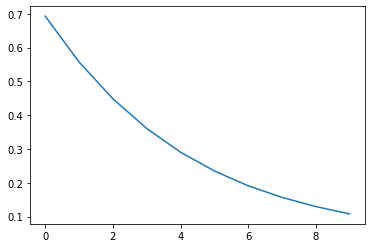

In [23]:
plt.plot(RMS_list)

In [ ]:
sample_size = 1000
resample = True
'''
TODO: Test the one with the sampling
TODO: Implement the SGD one
TODO: Maybe implement it with torch, using either autograd or plain backprop
'''
icp_sample, R_list, T_list, _, RMS_list = icp_point_to_point_fast(cloud, ref, 25, 1e-4, sample_size, resample=resample)